# 1 Spectral analysis

## Creating the matrix

In [1]:
import pyedflib
import numpy as np

def signal_matrix_from_eeg(filename):
    """
    A method to obtain the (k, N) data point matrix of signals using the pyedflib package.
    Args:
        *filename*: str
            The filename to open.
    Returns:
        *sigbufs*: np.array
            A (k, N) matrix representing k channels and N samples.
        *frequency*: int
            The sample frequency of the given data.
        *signal_labels*: [str]
            The channel labels of the given data.
    References:
    .. [1] The PyEDFlib package. To read EDF+/BDF+ files.
           http://pyedflib.readthedocs.io/en/latest/#
    """
    f = pyedflib.EdfReader(filename)
    
    k, N = f.signals_in_file, f.getNSamples()[0]
           
    sigbufs = np.zeros((k, N, 1))
    for i in np.arange(k):
        sigbufs[i, :, 0] = f.readSignal(i)
        
    return sigbufs, f.getSampleFrequency(0), f.getSignalLabels()

### Retrieving the signals

In [2]:
signal_open, frequency_open, names_open = signal_matrix_from_eeg(filename='../0. Dataset/eeg_data/S038R01.edf')
signal_closed, frequency_closed, names_closed = signal_matrix_from_eeg(filename='../0. Dataset/eeg_data/S038R02.edf')
names_open = list(map(lambda x: x.replace('.',''), names_open))
names_closed = list(map(lambda x: x.replace('.',''), names_closed))

### Dictionaries to obtain names

Given the names of our channels, we obtain two important structures:

1. A dictionary of the form (index, name).
1. A dictionary of the form (name, index).

In [3]:
dict_names = {idx: name for idx, name in enumerate(names_open)}
dict_number = {name: idx for idx, name in enumerate(names_open)}

## Using Welsh method for Power Spectral Density

In [4]:
import matplotlib.pyplot as plt
from scipy import signal

def plot_psd_welch(signals, frequency, indexes, title, nps=160):
    for i in indexes:
        f, Pxx_den = signal.welch(x=signals[i, :, 0], fs=frequency, nperseg=nps, scaling='spectrum')
        plt.semilogy(f, Pxx_den)
    plt.title(title)
    plt.grid()
    plt.xlabel('frequency [Hz]')
    plt.ylabel('PSD [V**2/Hz]')
    plt.show()

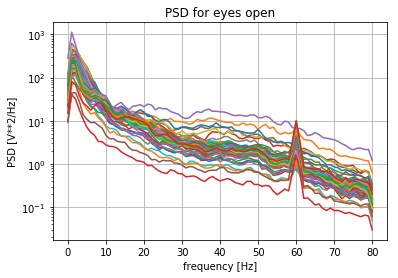

In [5]:
plot_psd_welch(signals=signal_open, frequency=160, title="PSD for eyes open", indexes=range(64))

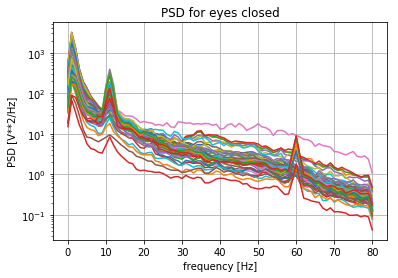

In [6]:
plot_psd_welch(signals=signal_closed, frequency=160, title="PSD for eyes closed", indexes=range(64))

As we can see, there's a peak around 10 Hz in the plot of the eyes closed experiment. The rhythm related to this frequency is the Alpha rhythm (in the band 8-13 Hz). According to the EEG analysis of channels, we should select a channel from the occipital lobe as the alpha rhythm is predominatly originated in this area. 

## Selecting relevant channel

To analyze which channels are from the occipital lobe, we checked the documentation of the [EEG files](https://physionet.org/physiobank/database/eegmmidb/) and we know that:

1. The letters F, T, C, P and O stand for frontal, temporal, central, parietal, and occipital lobes, respectively.
1. A "z" refers to an electrode placed on the midline.
1. Even numbers (2,4,6,8) refer to electrode positions on the right hemisphere, whereas odd numbers (1,3,5,7) refer to those on the left hemisphere.

Therefore, we need all channels with an O in the identifier. We have then two options to select the channels. 

1. Selecting manually the identifiers seeing the following picture:
    ![Occipital lobes channels](../All/img/O_zone.png)
    Therefore, we know that the channels are in names and numbers respectively:
    - $PO_7$, $PO_3$, $PO_z$, $PO_4$, $PO_8$, $O_1$, $O_z$, $O_2$.
    - [55, 62] (Remember that the identifiers from the picture are from 1 to 64). 
1. Filtering the object **names_closed** selecting those indexes with an 'O' or 'o' in the channel name.

We will now follow this three steps to select the relevant channel:

1. Select the signals with O's identifiers.
1. Plot this signals and plot the complement signals to compare results.
1. Finally, if the behaviour of 1. is as expected, select the channel that maximizes the PSD in the band 8-13 Hz.

### Selecting O's identifiers

Even though we know the identifiers, let's check that we're correct selecting those identifiers with an 'o' in the channel name:

In [7]:
occipital_lobe = list(idx for idx, names in enumerate(names_closed) if 'o' in names.lower())
rest_of_channels = list(set(range(64)).difference(set(occipital_lobe)))
print("Occipital indexes:", " ".join(map(str, occipital_lobe)))

Occipital indexes: 55 56 57 58 59 60 61 62


### Plot the signals in occipital lobe and complement

#### Eyes open case

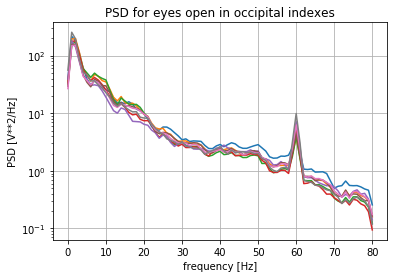

In [8]:
plot_psd_welch(signals=signal_open, frequency=160, title="PSD for eyes open in occipital indexes", indexes=occipital_lobe)

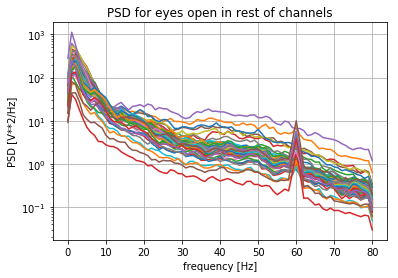

In [9]:
plot_psd_welch(signals=signal_open, frequency=160, title="PSD for eyes open in rest of channels", indexes=rest_of_channels)

#### Eyes closed case

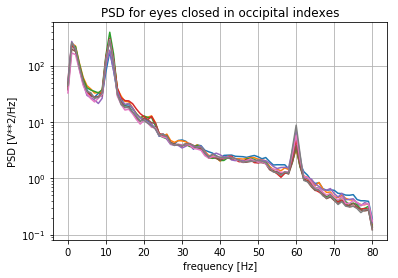

In [10]:
plot_psd_welch(signals=signal_closed, frequency=160, title="PSD for eyes closed in occipital indexes", indexes=occipital_lobe)

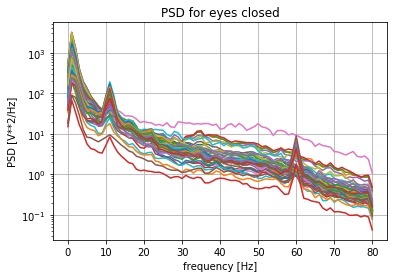

In [11]:
plot_psd_welch(signals=signal_closed, frequency=160, title="PSD for eyes closed", indexes=rest_of_channels)

### Selecting the relevant channel

We now select the channel that maximixes PSD in the occipital lobe identifiers in the range [8-13] Hz.

In [12]:
def select_relevant_channel(signals, frequency, indexes, nps=160):
    channel_of_interest, best_frequency, max_pxx = 0, 0, 0
    for i in indexes:
        f, Pxx_den = signal.welch(x=signals[i, :, 0], fs=frequency, nperseg=nps)
        alpha_interest = np.where((f >= 8) & (f <= 13))
        best_index = np.argmax(Pxx_den[alpha_interest[0]])+8

        if max(max_pxx, Pxx_den[best_index]) > max_pxx:
            max_pxx = Pxx_den[best_index]
            channel_of_interest = i
            best_frequency = f[best_index]
    return channel_of_interest, best_frequency

In [13]:
channel_of_interest, best_frequency = select_relevant_channel(signals=signal_closed, frequency=160, indexes=occipital_lobe)
print("The channel of interest is: {} with frequency {} Hz".format(channel_of_interest, best_frequency))

The channel of interest is: 57 with frequency 11.0 Hz


In [14]:
def compare_closed_open(signal_open, signal_closed, best_channel, frequency, title, nps=160):
    f, Pxx_den = signal.welch(x=signal_open[best_channel, :, 0], fs=frequency, nperseg=nps)
    plt.semilogy(f, Pxx_den)
    f, Pxx_den = signal.welch(x=signal_closed[best_channel, :, 0], fs=frequency, nperseg=nps)
    plt.semilogy(f, Pxx_den)
    plt.title(title)
    plt.grid()
    plt.xlabel('frequency [Hz]')
    plt.ylabel('PSD [V**2/Hz]')
    plt.legend(['Eyes open', 'Eyes closed'])
    plt.show()

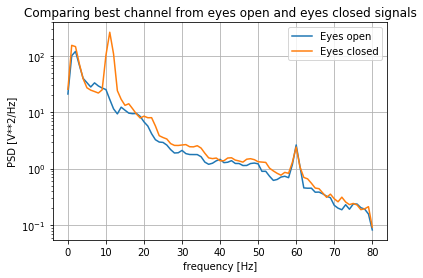

In [15]:
compare_closed_open(signal_open=signal_open,
                    signal_closed=signal_closed,
                    best_channel=channel_of_interest,
                    frequency=160,
                    title="Comparing best channel from eyes open and eyes closed signals")

# 2 Connectivity graph

## 2.1 (Mandatory) Creating the connectivity graph

In this part, we will estimate the **functional brain connectivity** obtaining the so called **connectivity graph** associated to our experiments taking into account the 64 channels and one of the following MVAR estimators:

1. Partial Directed Coherence (PDC)
1. Direct Transfer Function (DTF).

After applying this methods, we will select the matrix related to our relevant frequency value of 11 Hz so that applying a threshold we have a resulting binary matrix with a given density. Part 2.1 forces the density to 20% but we can generalize to any given density. Finally, we will plot a graphical representation of the resulting binary matrix.

### 2.1.a Obtaining the mvar model with DTF

#### 2.1.a.I Obtaining best order p

1) Eyes-open model

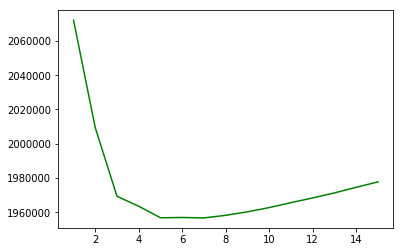

7


In [16]:
import connectivipy as cp
import matplotlib.pyplot as plt

models = {}

# assign static class cp.Mvar to variable mv
mv = cp.Mvar

# find best model order using Vieira-Morf algorithm
best_open, crit = mv.order_akaike(signal_open, 15, 'vm')
plt.plot(1+np.arange(len(crit)), crit, 'g')
plt.show()
print(best_open)

2) Eyes-closed

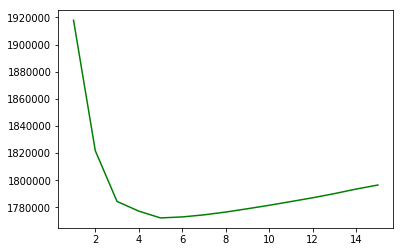

5


In [17]:
# assign static class cp.Mvar to variable mv
mv = cp.Mvar

# find best model order using Vieira-Morf algorithm
best_closed, crit = mv.order_akaike(signal_closed, 15, 'vm')
plt.plot(1+np.arange(len(crit)), crit, 'g')
plt.show()
print(best_closed)

#### 2.1.b.II Fitting the mvar model 

In [18]:
# Transforming matrix to connectivipy 
data_open = cp.Data(data=signal_open, 
                  fs=frequency_open,
                  chan_names=names_open)

# Fitting the mvar model using Yule-Walker algorithm
data_open.fit_mvar(best_open, 'yw')

In [19]:
# Transforming matrix to connectivipy 
data_closed = cp.Data(data=signal_closed, 
                  fs=frequency_closed,
                  chan_names=names_closed)

# Fitting the mvar model using Yule-Walker algorithm
data_closed.fit_mvar(best_closed, 'yw')

We now fit the model for both open and closed

In [20]:
dtf = cp.conn.DTF()

# For the open case
av_open, vf_open = data_open.mvar_coefficients
dtfval_open = dtf.calculate(av_open, vf_open, frequency_open)

# For the close case
av_closed, vf_closed = data_closed.mvar_coefficients
dtfval_closed = dtf.calculate(av_closed, vf_closed, frequency_closed)

### 2.1.c Finding the best alpha

We now create the adjacency giving the output of DFT. As we want to create a directed graph, we assume that result matrix will not be symmetric. Also, we fill the output diagonal with zeros to avoid edges $\left(i,i\right) \forall i$.

As the desired density is 0.2 we will calculate the best value in order to find this density from $64*64-64 = 64*63 = 4032$ possible edges. 

If $\displaystyle \frac{x}{4032} = 0.2 \rightarrow x = 4032*0.2 = 806.4$ 

We need to find the alpha ($\alpha$) such that the number of edges in the network is as close to 806 as possible. To do this, we implement a similar method to binary search in which we try to find the closest possible value that reach the desired density 0.2. As a result, we start our search from the space of $\alpha$ which is the interval $\left(0, 1\right)$.

Notes:

1. We assume that the need to find the closest possible alpha ($\alpha$) such that the density is **at least** 0.2. As $\displaystyle \frac{x}{4032}$ is not an integer, our algorithm stops with the closes integer $x$ such that $x>806.4$.
1. We stop when the closest integer doesn't change in 2 iterations.
1. It's possible that a density $d_l$ that denotes a lower bound such that $d_l < 0.2$ is closer to 0.2 than the output of our algorithm. However, we finding the alpha such that $d_\alpha-0.2>0$ with $d_\alpha$ denoting the density of the binary matrix using $\alpha$ threshold.

In [21]:
# Selecting the matrix in the desired frequency
matrix_open = dtfval_open[int(best_frequency), :, :].reshape((64, 64))
np.fill_diagonal(matrix_open, 0)

matrix_closed = dtfval_closed[int(best_frequency), :, :].reshape((64, 64))
np.fill_diagonal(matrix_closed, 0)

In [22]:
def find_best_alpha(interest, desired_density=0.2, tol=1e-3, N=64, n_iter=100, debug=True):
    search_space = [0.0, 1.0]
    density, i = 0, 0
    best_alpha, this_alpha, best_n = -1, 0, 4096
    target = int(N*(N-1)*desired_density)
   
    if debug:
        print("Desired number of nodes: {} for desired density {}".format(target, desired_density))
    
    while best_alpha != this_alpha:
        best_alpha = this_alpha
        for alpha in np.arange(search_space[0], search_space[1], (search_space[1] - search_space[0])/100.0):
            n = len(np.where(interest > alpha)[0])
            if abs(n-target) < abs(best_n-target) and n-target>0:
                this_alpha, best_n = alpha, n
        if debug:
            print("In search_space({:0.3f},{:0.3f}) alpha: {:0.3f} best_n: {} proportion: {:0.3f}".format(search_space[0], 
                                                                                                       search_space[1], 
                                                                                                       this_alpha, 
                                                                                                       best_n, 
                                                                                                       best_n/(N*(N-1))))
        search_space[0], search_space[1] = this_alpha-tol, this_alpha+tol

    return best_alpha

#### Finding the best alpha for boths open and closed

In [23]:
best_alpha_open = find_best_alpha(interest=matrix_open,
                                  desired_density=0.2,
                                  tol=1e-3)

Desired number of nodes: 806 for desired density 0.2
In search_space(0.000,1.000) alpha: 0.120 best_n: 872 proportion: 0.216
In search_space(0.119,0.121) alpha: 0.121 best_n: 861 proportion: 0.214
In search_space(0.120,0.122) alpha: 0.122 best_n: 847 proportion: 0.210
In search_space(0.121,0.123) alpha: 0.123 best_n: 843 proportion: 0.209
In search_space(0.122,0.124) alpha: 0.124 best_n: 833 proportion: 0.207
In search_space(0.123,0.125) alpha: 0.125 best_n: 822 proportion: 0.204
In search_space(0.124,0.126) alpha: 0.125 best_n: 812 proportion: 0.201
In search_space(0.124,0.126) alpha: 0.126 best_n: 807 proportion: 0.200
In search_space(0.125,0.127) alpha: 0.126 best_n: 807 proportion: 0.200


In [24]:
best_alpha_closed = find_best_alpha(interest=matrix_closed,
                                    desired_density=0.2,
                                    tol=1e-3)

Desired number of nodes: 806 for desired density 0.2
In search_space(0.000,1.000) alpha: 0.130 best_n: 837 proportion: 0.208
In search_space(0.129,0.131) alpha: 0.131 best_n: 820 proportion: 0.203
In search_space(0.130,0.132) alpha: 0.132 best_n: 810 proportion: 0.201
In search_space(0.131,0.133) alpha: 0.132 best_n: 807 proportion: 0.200
In search_space(0.131,0.133) alpha: 0.132 best_n: 807 proportion: 0.200


### (2.1.d - 2.5) Creation and topological representation of the graph

We will unify last points of 2.1 and 2.5 in one question. Creating the topological representation of the graph is setting the position of the constructor of the directed graph (DiGraph).

#### Getting position data

In [25]:
import pandas as pd
import networkx as nx

In [26]:
def create_position_graph(filename):    
    location = pd.read_csv(filename, sep="\t", encoding='latin-1', index_col=0)
    position_data = {label.replace('.', ''): (x, y) for label, x, y in zip(location['label'], location['x'], location['y'])}
    
    return position_data

In [27]:
position_data = create_position_graph('../All/location_data/channel_locations.txt')

#### Creating the graphs

To create the graphs, we decided to use the **Di**rected**Graph** class from networkx. Our constructors receive a boolean weighted depending on the desired type of graph depending on user's choice.

In [28]:
def create_edges_list(input_matrix, alpha, weighted=False):
    x, y = np.where(input_matrix > alpha)
        
    if weighted:
        return list(zip(map(lambda idx: dict_names[idx], x), 
                        map(lambda idy: dict_names[idy], y), 
                        map(lambda x: input_matrix[x[0]][x[1]], list(zip(x, y))))) 
    else:
        return list(zip(map(lambda idx: dict_names[idx], x), map(lambda idy: dict_names[idy], y)))

def create_directed_graph(input_matrix, alpha, position, weighted=False):
    G = nx.DiGraph()
    G.add_nodes_from(position_data.keys(), style='filled',fillcolor='red', pos=position, nodesize=10)
    
    if weighted:
        G = nx.DiGraph((x, y, {'weight':w}) for (x, y, w) in create_edges_list(input_matrix, alpha, weighted=True))
    else:
        G.add_edges_from(create_edges_list(input_matrix, alpha))
    
    return G

Graph for open case

In [29]:
directed_graph_open = create_directed_graph(input_matrix=matrix_open,
                                            alpha=best_alpha_open,
                                            position=position_data)

Graph for closed case

In [30]:
directed_graph_closed = create_directed_graph(input_matrix=matrix_closed,
                                              alpha=best_alpha_closed,
                                              position=position_data)

#### Topological representations

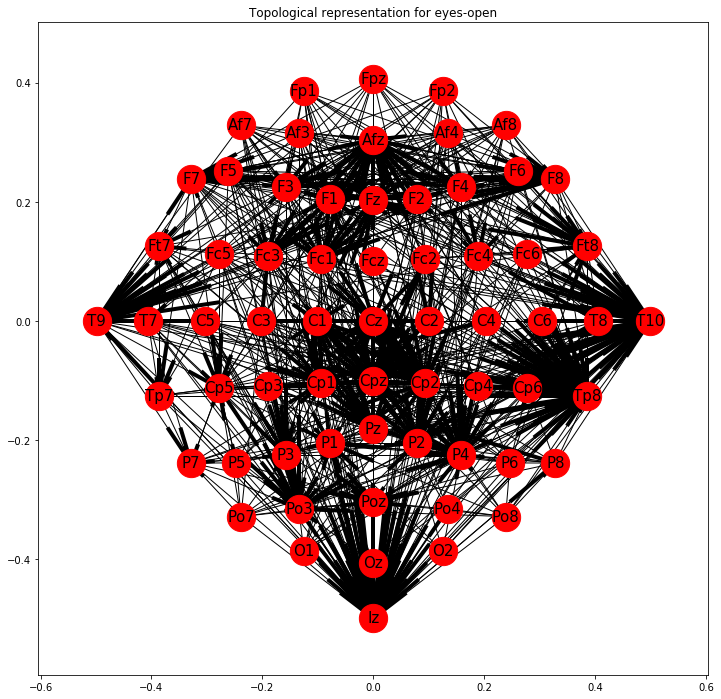

In [31]:
plt.figure(figsize=(12,12)) 
nx.draw_networkx(directed_graph_open, position_data, node_size=800, font_size=15)
plt.title('Topological representation for eyes-open')
plt.show()

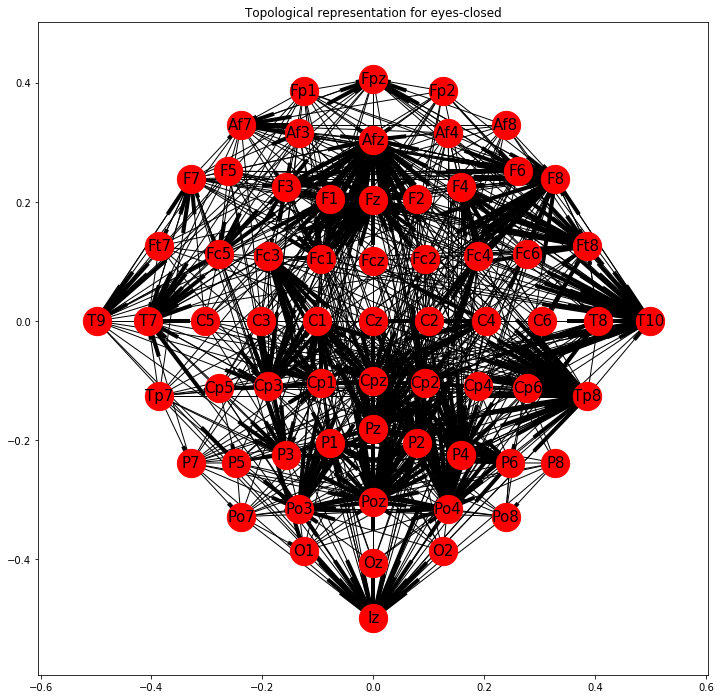

In [32]:
plt.figure(figsize=(12,12)) 
nx.draw_networkx(directed_graph_closed, position_data, node_size=800, font_size=15)
plt.title('Topological representation for eyes-closed')
plt.show()

### 2.1.e Drawing the adjacency matrixes

In [33]:
def create_adjacency_matrix(interest, alpha):
    return np.array(interest > alpha, dtype=np.int)

Computing binary matrix for open case

In [34]:
binary_matrix_open = create_adjacency_matrix(matrix_open, best_alpha_open)

Computing binary matrix for closed case

In [35]:
binary_matrix_closed = create_adjacency_matrix(matrix_closed, best_alpha_closed)

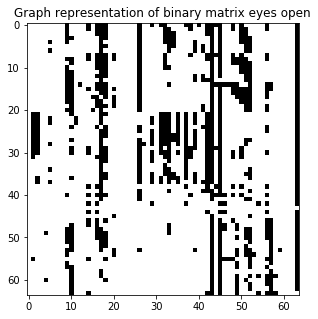

In [36]:
fig = plt.figure(figsize=(5, 5)) # in inches
plt.imshow(binary_matrix_open,
              cmap="Greys",
              interpolation="none")
plt.title('Graph representation of binary matrix eyes open')
plt.show()

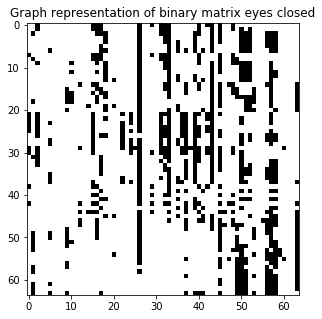

In [37]:
fig = plt.figure(figsize=(5, 5)) # in inches
plt.imshow(binary_matrix_closed,
              cmap="Greys",
              interpolation="none")
plt.title('Graph representation of binary matrix eyes closed')
plt.show()

# 3 Graph  theory  indices
## 3.1. (Mandatory) Compute binary global (clustering coefficient, path length) and local (degree, in/out-degree) graph indices. List the highest 10 channels for local indices.

In this part, we compute the global **clustering coefficient** and **path length** and local **in/out-degree** of the graph previously generated.

In order to save time we computed the communities we needed also for the 5.1 on the same function.


In [38]:
import louvain 
from igraph import *
import pandas as pd
import igraph as ig

In [39]:
def graph_theory_indices(g_nx):
    #computing the average_clustering coefficient
    lcc = max(nx.connected_components(g_nx.to_undirected()), key=len)
    
    average_clustering_coefficient = nx.average_clustering(g_nx.to_undirected().subgraph(list(lcc)))
    #converting into igraph
    g = ig.Graph.TupleList(g_nx.edges(), directed=True)
    #generating the clustering using louvain
    clustering = {}
    partition = louvain.find_partition(g, louvain.ModularityVertexPartition)
    for i in range(len(partition)):
        clustering[i]=partition[i]
    #computing the average_path_length
    average_path_length = g.average_path_length()
    #generating the data-frame with the nodes and its degree information
    vs = VertexSeq(g)
    vertex = []
    indegree = []
    outdegree = []
    degree = []
    for i in vs:
        vertex.append(i['name'])
        indegree.append(g.degree(i['name'], type="in"))
        outdegree.append(g.degree(i['name'], type="out"))
        degree.append(g.degree(i['name']))
    d = {'vertex': vertex, 'in-degree': indegree, 'out-degree': outdegree,'degree': degree}
    degree_info = pd.DataFrame(data=d)
    degree_info = degree_info[['vertex', 'in-degree', 'out-degree', 'degree']]
    degree_info=degree_info.sort_values(by=['degree'], ascending=False)
    return(clustering, average_clustering_coefficient, average_path_length, degree_info)
 #remember to degree_info.head(10)

Getting the information for both graphs

In [41]:
(clustering_open, average_clustering_open, average_path_length_open, degree_info_open) = graph_theory_indices(directed_graph_open)
(clustering_close, average_clustering_close, average_path_length_close, degree_info_close) = graph_theory_indices(directed_graph_closed)

/home/alba/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:23: DeprecationWarning: type=... keyword argument is deprecated since igraph 0.6, use mode=... instead
/home/alba/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:24: DeprecationWarning: type=... keyword argument is deprecated since igraph 0.6, use mode=... instead


## global info

In [42]:
average_clustering_open

0.6806835812912677

In [43]:
average_clustering_close

0.6528626309490608

In [44]:
average_path_length_open

1.9494059026446915

In [45]:
average_path_length_close

2.1103278110680295

## local info

In [46]:
#this function saves the data frame as csv on the same folder with name s
def saving(solution, s):
    sol = pd.DataFrame(solution)
    sol.to_csv(s+'.csv',index=False)

The information of **in/out-degree** is stored in the data frame degree_info, as we were asked, we only show the TOP-10.

In [47]:
sol_open = degree_info_open.head(10)
sol_open

,vertex,in-degree,out-degree,degree
20,Iz,62,10,72
16,Tp8,60,4,64
4,Cpz,48,15,63
14,T10,60,0,60
6,Afz,38,16,54
27,Cz,33,13,46
5,Cp2,34,12,46
28,P4,35,8,43
1,C1,25,14,39
23,P2,29,9,38


In [48]:
sol_close = degree_info_close.head(10)
sol_close

,vertex,in-degree,out-degree,degree
5,Afz,56,19,75
22,Poz,50,8,58
9,Fz,41,12,53
13,Tp8,43,10,53
16,Pz,41,10,51
12,T10,40,8,48
42,Iz,28,16,44
29,F8,29,15,44
23,Po4,34,8,42
19,Ft8,28,10,38


In [49]:
saving(sol_open, 'degree_info_open')
saving(sol_close, 'degree_info_close')

## 3.4- (class ‘C’) Study the behaviour of global graph indices in function of network density.

In order to study the behaviour for different densities we wrote the following function:

In [50]:
def behaviour_density(interest_matrix, densities=[0.01, 0.05, 0.1, 0.2, 0.3, 0.5]):
    global_clustering, global_path_length, best_alphas = [], [], []
    
    for density in densities:
        best_alpha = find_best_alpha(interest=interest_matrix, 
                                     desired_density=density, 
                                     tol=1e-3,
                                     debug=False)
        
        best_alphas.append(best_alpha)
        
        community_graph = create_directed_graph(input_matrix=interest_matrix,
                                                alpha=best_alpha,
                                                position=position_data)
        
        _, clustering, average_path_length, _  =graph_theory_indices(community_graph)
        
        global_clustering.append(clustering)
        global_path_length.append(average_path_length)
    
    d = {'Clustering coefficient': global_clustering, 
         'Average path length':global_path_length,
         'Densities': densities,
         'Best alpha': best_alphas}
    
    behaviour_df = pd.DataFrame(data=d)
    
    return behaviour_df[['Densities', 'Best alpha', 'Clustering coefficient', 'Average path length']]

We stored all the information in the following dataframes:

In [52]:
behaviour_open = behaviour_density(interest_matrix=matrix_open)
behaviour_close = behaviour_density(interest_matrix=matrix_closed)

/home/alba/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:23: DeprecationWarning: type=... keyword argument is deprecated since igraph 0.6, use mode=... instead
/home/alba/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:24: DeprecationWarning: type=... keyword argument is deprecated since igraph 0.6, use mode=... instead


In [53]:
saving(behaviour_open, 'behaviour_open')
behaviour_open

,Densities,Best alpha,Clustering coefficient,Average path length
0,0.01,0.30000,0.295062,1.534247
1,0.05,0.21090,0.460552,2.218563
2,0.10,0.17928,0.600191,2.513357
3,0.20,0.12598,0.680684,1.949406
4,0.30,0.09798,0.729145,1.750388
5,0.50,0.06406,0.823024,1.488185


In [54]:
saving(behaviour_close, 'behaviour_close')
behaviour_close

,Densities,Best alpha,Clustering coefficient,Average path length
0,0.01,0.33000,0.042602,1.222222
1,0.05,0.21324,0.564534,2.473819
2,0.10,0.16904,0.547150,2.465508
3,0.20,0.13198,0.652863,2.110328
4,0.30,0.10876,0.686687,1.816712
5,0.50,0.07654,0.819633,1.497268


Studying the best alpha, we got that the bigger the density the smaller the alpha. A behaviour expected because of the definition of alpha.

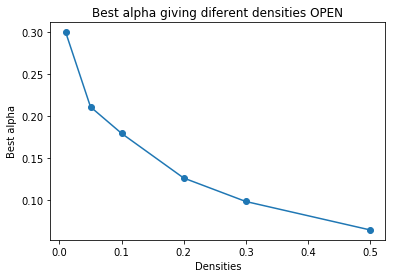

In [55]:
fig = plt.figure() #THIS
plt.plot(behaviour_open['Densities'], behaviour_open['Best alpha'], '-o', color='C0')
plt.xlabel('Densities')
plt.ylabel('Best alpha')
plt.title("Best alpha giving diferent densities OPEN")
plt.show()
fig.savefig('best_alpha_open.jpg')#AND THIS IS IMPORTANT TO SAVE PLOTS

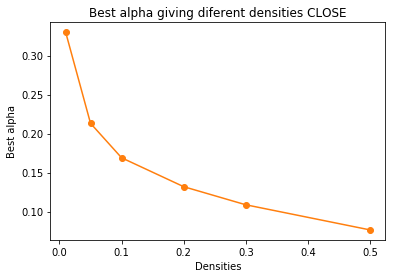

In [56]:
fig = plt.figure() #THIS
plt.plot(behaviour_close['Densities'], behaviour_close['Best alpha'], '-o', color='C1')
plt.xlabel('Densities')
plt.ylabel('Best alpha')
plt.title("Best alpha giving diferent densities CLOSE")
plt.show()
fig.savefig('best_alpha_close.jpg')#AND THIS IS IMPORTANT TO SAVE PLOTS

Studying the clustering coefficient, we got that the bigger the density, the bigger the alpha. A behaviour expected because of the definition of Clusteing coefficient.

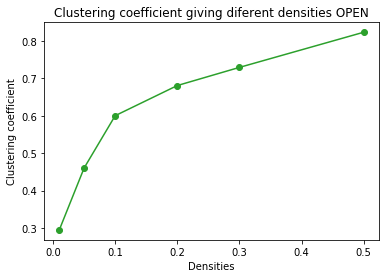

In [57]:
fig = plt.figure() #THIS
plt.plot(behaviour_open['Densities'], behaviour_open['Clustering coefficient'], '-o', color='C2')
plt.xlabel('Densities')
plt.ylabel('Clustering coefficient')
plt.title("Clustering coefficient giving diferent densities OPEN")
plt.show()
fig.savefig('clustering_coefficient_open.jpg')#AND THIS IS IMPORTANT TO SAVE PLOTS

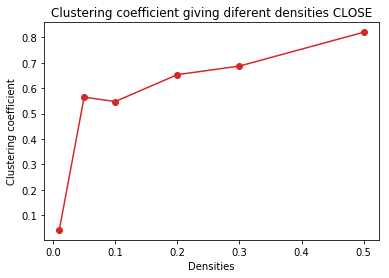

In [58]:
fig = plt.figure() #THIS
plt.plot(behaviour_close['Densities'], behaviour_close['Clustering coefficient'], '-o', color='C3')
plt.xlabel('Densities')
plt.ylabel('Clustering coefficient')
plt.title("Clustering coefficient giving diferent densities CLOSE")
plt.show()
fig.savefig('clustering_coefficient_close.jpg')#AND THIS IS IMPORTANT TO SAVE PLOTS

Studying the average path length, we can see that: when the density is little the graph is not connected so when the average path length is computed it is done on the connected part and since the number of nodes into it is little the average path length is also little. As soon as the density is enough to make the graph connected, the average path length grows rapidly and from this point, as the density increases the average path length decreases and it will end up being 1 when the density is equal to 1 so the graph is complete.

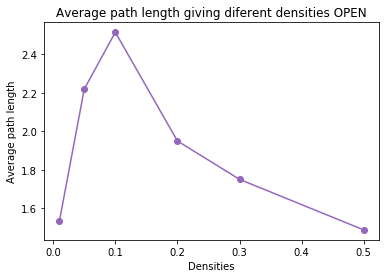

In [59]:
fig = plt.figure() #THIS
plt.plot(behaviour_open['Densities'], behaviour_open['Average path length'], '-o', color='C4')
plt.xlabel('Densities')
plt.ylabel('Average path length')
plt.title("Average path length giving diferent densities OPEN")
plt.show()
fig.savefig('average_path_length_open.jpg')#AND THIS IS IMPORTANT TO SAVE PLOTS

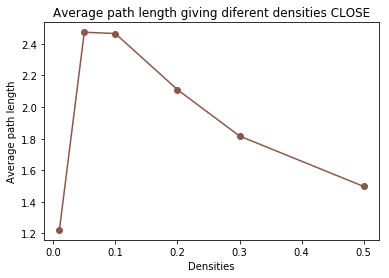

In [60]:
fig = plt.figure() #THIS
plt.plot(behaviour_close['Densities'], behaviour_close['Average path length'], '-o', color='C5')
plt.xlabel('Densities')
plt.ylabel('Average path length')
plt.title("Average path length giving diferent densities CLOSE")
plt.show()
fig.savefig('average_path_length_close.jpg')#AND THIS IS IMPORTANT TO SAVE PLOTS

# 4 Motifs

## 4.0 Creating output for mfinder

We analyze the input of mfinder:

        Input file format
        ==================

        Input network file format should be a simple ".txt" format.
        Nodes in the network should be represented by integers.
        Each edge in the network should be represented by an 
        equivalent line of the following format:

        <target node> <source node> <edge value>.

        -In the current version <edge value> is ignored and should 
         be 1 for all edges.
        -The number of nodes in the network is considered as the
         highest integer (that represent a node) to appear in the file.
         
The important features are:

1. An edge u->v is written in the form v u 1.
1. The number of nodes in the network is considered as max(id_1, ...,id_n).

With point 1 we just need to adapt to the format and with point 2 we must change our id's to id+1 as our range is from 0 to 63.

In [61]:
with open('../All/mfinder/input/directed_open.txt', 'w') as directed_file:
    for init, destiny in directed_graph_open.edges():
        directed_file.write("\t".join(map(str, [dict_number[init]+1, dict_number[destiny]+1, 1]))+"\n")

FileNotFoundError: [Errno 2] No such file or directory: '../All/mfinder/input/directed_open.txt'

In [62]:
with open('../All/mfinder/input/directed_closed.txt', 'w') as directed_file:
    for init, destiny in directed_graph_closed.edges():
        directed_file.write("\t".join(map(str, [dict_number[init]+1, dict_number[destiny]+1, 1]))+"\n")

FileNotFoundError: [Errno 2] No such file or directory: '../All/mfinder/input/directed_closed.txt'

### a) Analysis of input

        Command line flags:
        ===================
        -s :  Motif size to detect (currently can be 3 or 4).
            Default: 3

        -r :  Number of random networks to generate.                
            Default: 100

        -f :  Output file name. a suffix "__OUT.txt" is automatically added. 
              Default: <input network file name>__OUT.txt
              
        -nd : Input network is non-directed. (See input file format for this case)
               Default: Directed.

        -omem : Output members of all the motifs that were found.

        -h :  for help.

        (Or you can just type "mfinder.exe" for help).
    
Basically, we need to run 3 types of commands taking into account our needs:

1. To create 3-motifs:
        mfinder1.2/mfinder1.2.exe <input_file_graph> -s <n-motifs> -r <random_networks> -f <output_file>
1. To create 3-motifs:
        mfinder1.2/mfinder1.2.exe <input_file_graph> -s <n-motifs> -r <random_networks> -f <output_file>
1. To obtain motifs associated to a structure.
        mfinder1.2/mfinder1.2.exe <input_file_graph> -s <n-motifs> -r <random_networks> -f <output_file> -omem <id_structure>


### b) Automatic generation of files

In [63]:
import shlex, subprocess

params = {
    "path": "../All/mfinder/",
    "executable": "mfinder1.2.exe",
    "_input": "input/directed_open.txt",
    "motifs": 3,
    "simulations": 100,
    "output": "3-motifs/open_3_motifs"
}

format_mfinder = "{path}{executable} {path}{_input} -s {motifs} -r {simulations} -f {path}{output}".format(path=params["path"],
                                                                                                           motifs=params["motifs"],
                                                                                                           executable=params["executable"],
                                                                                                           _input=params["_input"],
                                                                                                           simulations=params["simulations"],
                                                                                                           output=params["output"])

print(format_mfinder)
executable = "{path}{executable}".format(path=params["path"],
                                         executable=params["executable"])

p = subprocess.Popen(shlex.split(format_mfinder))

../All/mfinder/mfinder1.2.exe ../All/mfinder/input/directed_open.txt -s 3 -r 100 -f ../All/mfinder/3-motifs/open_3_motifs


FileNotFoundError: [Errno 2] No such file or directory: '../All/mfinder/mfinder1.2.exe': '../All/mfinder/mfinder1.2.exe'

## 4.1 (mandatory) Motifs analysis

**Description**: Perform motifs analysis to investigate the presence of 3-node configurations in the networks: determine their frequency and statistical significance (motifs, anti-motifs).


In [64]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import pyedflib
import re

In [65]:
def motif_analysis(filename, pattern='Full list of subgraphs size 3 ids:', n_motifs=13):
    
    # read the file
    
    file = open(filename, 'r', encoding='utf8')
    f = ''
    for row  in file: 
        f += row
    
    columns = ['ID', 'Frequency', "intervals", 'Statistical Significance', 'z-score', 'p-value']
    dictionary = {c: [] for c in columns}
    intervals = []

    l = f.split(pattern)[1].split('\n')
    
    for idx, row in enumerate(l):
        data = row.split('\t')
        if data[0] == '':
            continue

        if '+-' in row:
            dictionary[columns[0]] += [int(data[0])]
            dictionary[columns[1]] += [int(data[1])]
            intervals += [row.split()[2]]
            dictionary['z-score'] += [float(data[3])]
            dictionary['p-value'] += [float(data[4])]
    dictionary["intervals"] = intervals

    intervals = [[float(i.split('+-')[0])-float(i.split('+-')[1]), float(i.split('+-')[0])+float(i.split('+-')[1])] 
                 for i in intervals]
    
    for i in range(n_motifs):
        if dictionary['Frequency'][i] > intervals[i][1]:
            dictionary['Statistical Significance'] += ['motif']
        elif dictionary['Frequency'][i] < intervals[i][0]:
            dictionary['Statistical Significance'] += ['anti-motif']
        else:
            dictionary['Statistical Significance'] += ['no significant']

    dictionary = pd.DataFrame(dictionary, columns = columns)
    return(dictionary)

In [66]:
path = '../All/mfinder/3-motifs/'
files = ['closed_3_motifs_OUT.txt', 'open_3_motifs_OUT.txt']
d = []

# For this moment we have only a file, i.e. 'output_exmp.txt'. 
# We need to change the files and add the pdc of the opened eyes graph and the pdc of the closed eyes

for f in files:
    d += [motif_analysis(path+f)]
closed_motifs = d[0]
open_motifs = d[1]

FileNotFoundError: [Errno 2] No such file or directory: '../All/mfinder/3-motifs/closed_3_motifs_OUT.txt'

In [67]:
closed_motifs

NameError: name 'closed_motifs' is not defined

In [68]:
open_motifs

NameError: name 'open_motifs' is not defined

## 4.2. **(class C)** Finding:

**Description:** For the motif with pattern A → B ← C , create a topographical representation of the networks considering only the connections involved in this configuration.

To analyze this motif, we need to identify the index of the motifs used in mfinder. In the following image, we can understand that we are looking for the motifs with identifier 36.

![3 motifs format in mfinder](../All/img/motifs.PNG)

Next, to obtain the patterns associated to this motifs, we run the following command:

         ./mfinder1.2.exe network_exmp.txt -s 3 -r 100 -f 36 -ospmem 36


In [69]:
def edges_function(filename):
    file = open(filename, 'r')
    f = ''
    for row  in file: 
        f += row
       
    edges = []

    for m in f.split('\n'):
        if '\t' in m:
            edges += [(int(m.split('\t')[0])-1, int(m.split('\t')[2])-1)]
            edges += [(int(m.split('\t')[1])-1, int(m.split('\t')[2])-1)]
    return(edges)

def obtain_motifs(filename, motif_look, dict_na):
    file = open(filename, 'r')
    f = ''
    for row  in file: 
        f += row
       
    mofits = []

    for m in f.split('\n'):
        if '\t' in m:
            left, right, center = map(int, m.split('\t')[0:3])
            if left is motif_look or right is motif_look or center is motif_look: 
                mofits.append("{}->{}<-{}".format(dict_na[left-1], dict_na[center-1], dict_na[right-1]))
    return mofits

In [70]:
path = '../All/mfinder/3-motifs/'
files_36 = ['closed_3_motifs_36_MEMBERS.txt', 'open_3_motifs_36_MEMBERS.txt']
edges_list = []

for f in files_36:
    edges_list += [list(set(edges_function(path+f)))]

edges_list_36_closed = edges_list[0]
print("Edges in graph closed with configuration 36:", len(edges_list_36_closed))
edges_list_36_open = edges_list[1]
print("Edges in graph open with configuration 36:", len(edges_list_36_open))


FileNotFoundError: [Errno 2] No such file or directory: '../All/mfinder/3-motifs/closed_3_motifs_36_MEMBERS.txt'

### Creating topological representation using only edges from configuration 36

#### Closed case

In [71]:
edges_list_36_closed = [(dict_names[init], dict_names[destiny]) for (init, destiny) in edges_list_36_closed]
vertex_36_closed = set()
for init, destiny in edges_list_36_closed:
    vertex_36_closed.update([destiny, init])

NameError: name 'edges_list_36_closed' is not defined

In [72]:
graph_36_closed = nx.DiGraph()
graph_36_closed.add_edges_from(edges_list_36_closed)
position_data_closed = {(x, y) for (x, y) in position_data.items() if x in list(vertex_36_closed)}

NameError: name 'edges_list_36_closed' is not defined

In [73]:
plt.figure(figsize=(12,12))
nx.draw_networkx(graph_36_closed, dict(position_data_closed), node_size=800, font_size=15)
plt.title('Topological representation for eyes-closed of mofits')
plt.show()

NameError: name 'position_data_closed' is not defined

#### Open case

In [74]:
edges_list_36_open = [(dict_names[init], dict_names[destiny]) for (init, destiny) in edges_list_36_open]
vertex_36_open = set()
for init, destiny in edges_list_36_open:
    vertex_36_open.update([init, destiny])

NameError: name 'edges_list_36_open' is not defined

In [75]:
graph_36_open = nx.DiGraph()
graph_36_open.add_edges_from(edges_list_36_open)
position_data_open = {(x, y) for (x, y) in position_data.items() if x in list(vertex_36_open)}

NameError: name 'edges_list_36_open' is not defined

In [76]:
plt.figure(figsize=(12,12))
nx.draw_networkx(graph_36_open, dict(position_data_open), node_size=800, font_size=15)
plt.title('Topological representation for eyes-open of mofits')
plt.show()

NameError: name 'position_data_open' is not defined

## 4.3. **(class C)** Choosing channel in parieto-occipital scalp region 

**Description**: Choosing channel in  a channel selected in parieto-occipital scalp region and determine the motifs which involve it.

We select the channel $Poz$

### Motifs involving $Poz$ in closed graph


In [77]:
paths = '../All/mfinder/3-motifs/'
files_36 = ['closed_3_motifs_36_MEMBERS.txt', 'open_3_motifs_36_MEMBERS.txt']
motifs_list = []

for path in files_36:
    motifs_list.append(obtain_motifs(filename=paths+path, motif_look=dict_number['Poz'], dict_na=dict_names))
    
print(motifs_list[0])

FileNotFoundError: [Errno 2] No such file or directory: '../All/mfinder/3-motifs/closed_3_motifs_36_MEMBERS.txt'

### Check if all motifs are in the graph

To ensure our analysis, let's check if all the motifs are in the graph.

In [78]:
def check_motifs_16(graph, motifs):
    for mofit in motifs_list[0]:
        u, r = mofit.split('->')
        v, z = r.split('<-')
        if all([directed_graph_closed.has_edge(u, v), directed_graph_closed.has_edge(z, v)]):
               print("Motif {}->{}<-{} failed".format(u, v, z))
    return "All motifs in graph!"

In [79]:
check_motifs_16(directed_graph_closed, motifs_list[0])

IndexError: list index out of range

In [80]:
check_motifs_16(directed_graph_open, motifs_list[1])

IndexError: list index out of range

## 4.4. **(class E)** Finding 4-node motifs. 

**Description**: Perform the same analysis described in task 4.1 considering 4-node motifs.

In this case, we have 199 possible motifs

In [81]:
path = '../All/mfinder/4-motifs/'
files = ['open_4_motifs_OUT.txt', 'closed_4_motifs_OUT.txt']
d = []

# For this moment we have only a file, i.e. 'output_exmp.txt'. 
# We need to change the files and add the pdc of the opened eyes graph and the pdc of the closed eyes

for f in files:
    d += [motif_analysis(path+f, pattern='Full list of subgraphs size 4 ids:', n_motifs=199)]
#closed_motifs = d[0]
open_motifs = d[0]
closed_motifs = d[1]

FileNotFoundError: [Errno 2] No such file or directory: '../All/mfinder/4-motifs/open_4_motifs_OUT.txt'

In [82]:
open_motifs.head(20)

NameError: name 'open_motifs' is not defined

In [83]:
closed_motifs.head(20)

NameError: name 'closed_motifs' is not defined

# 5 Community detection
## 5.1. (Mandatory) Determine number and composition (i.e. list of nodes) of the communities obtained applying one of the algorithms introduced during the course.

As we explained on the 3.1, we computed the communities on that exercise. We used Louvain algorithm. We kept this information in the dictionary called clustering. In order to make it more readable, we created the following function to show the information obtained in a data frame:

In [84]:
def community(clustering):
    number = []
    total = []
    nodes = []

    for i in clustering.keys():
        number.append(i)
        nodes.append(clustering[i])
        total.append(len(clustering[i]))
    
    d = {'community': number, 'total': total, 'nodes': nodes}
    
    community_detection = pd.DataFrame(data=d)
    community_detection = community_detection[['community', 'total', 'nodes']]
    community_detection['nodes'] = community_detection['nodes'].apply(lambda x: list(map(lambda y: dict_names[y], x)))
    return(community_detection)

In the following data frame you can see the communities information

In [85]:
community_info_open = community(clustering_open)
saving(community_info_open, 'community_info_open')
community_info_open

,community,total,nodes
0,0,24,"[Fc6, C5, C3, C1, Cz, C6, Fp1, Fpz, Af7, Af3, ..."
1,1,17,"[Fc3, Fcz, Fc2, Fc4, Cp2, Fp2, Afz, Af4, Af8, ..."
2,2,13,"[Cp5, Cp1, Cp4, Cp6, F8, T10, Po3, Poz, Po4, O..."
3,3,10,"[Fc5, Fc1, C2, C4, Cp3, Cpz, F2, T8, T9, Po8]"


In [86]:
community_info_close = community(clustering_close)
saving(community_info_close, 'community_info_close')
community_info_close

,community,total,nodes
0,0,24,"[Fcz, Fc2, C6, Cp3, Cp1, Cp2, Cp6, Fp1, Fpz, F..."
1,1,22,"[Fc5, Fc3, Fc1, Fc4, Fc6, C5, C3, C1, Cz, C2, ..."
2,2,12,"[C4, Cpz, Cp4, Af3, Afz, Af4, Af8, F5, Ft7, Ft..."
3,3,6,"[Cp5, F8, T7, T8, Poz, Po4]"
